In [1]:
!pip install imutils

In [2]:
import os
import cv2
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
from tensorflow.keras import metrics
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory 

plt.style.use('ggplot')

In [3]:
os.listdir("/kaggle/input/intel-image-classification/seg_pred")

['seg_pred']

## ***Load and Preprocess Data***

In [4]:
image_size = (299,299)
batch_size = 32

train_data_path = "/kaggle/input/intel-image-classification/seg_train/seg_train"
test_data_path = "/kaggle/input/intel-image-classification/seg_test/seg_test"

train_set = image_dataset_from_directory(train_data_path, 
                                         label_mode ='categorical',
                                         validation_split=0.2,
                                         subset="training",
                                         seed=1337,
                                         image_size=image_size,
                                         batch_size=batch_size)

validation_set = image_dataset_from_directory(train_data_path,
                                   label_mode ='categorical',
                                   validation_split=0.2,
                                   subset="validation",
                                   seed=1337,
                                   image_size=image_size,
                                   batch_size=batch_size)

test_set = image_dataset_from_directory(test_data_path,
                                   label_mode ='categorical',
                                   seed=1337,
                                   image_size=image_size,
                                   batch_size=batch_size)

m_train_set = train_set.map(lambda x, y: (preprocess_input(x), y))
m_validation_set = validation_set.map(lambda x, y: (preprocess_input(x), y))
m_test_set = test_set.map(lambda x, y: (preprocess_input(x), y))

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.


## ***Construction of Model***

In [5]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [6]:
baseModel = Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(299,299,3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(6, activation="softmax")(headModel)


model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = True
    
metrics = ['accuracy',metrics.Precision(name='precision'),metrics.Recall(name='recall')] 

opt = Adam(lr=INIT_LR, decay=INIT_LR/EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [8]:
plot_model(model, to_file='model.png', dpi=300)

In [9]:
HR2 = model.fit_generator(m_train_set, steps_per_epoch=16, validation_data = m_validation_set, validation_steps=8, epochs=EPOCHS)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
16/16 [==============================] - 26s 1s/step - loss: 1.7186 - accuracy: 0.2403 - precision: 0.1876 - recall: 0.0029 - val_loss: 1.3912 - val_accuracy: 0.7031 - val_precision: 1.0000 - val_recall: 0.0117
Epoch 2/20
16/16 [==============================] - 15s 965ms/step - loss: 1.2148 - accuracy: 0.6285 - precision: 0.8270 - recall: 0.1682 - val_loss: 0.8807 - val_accuracy: 0.8086 - val_precision: 0.9421 - val_recall: 0.4453
Epoch 3/20
16/16 [==============================] - 15s 967ms/step - loss: 0.8274 - accuracy: 0.7560 - precision: 0.8815 - recall: 0.4876 - val_loss: 0.5602 - val_accuracy: 0.8477 - val_precision: 0.8960 - val_recall: 0.7070
Epoch 4/20
16/16 [==============================] - 15s 968ms/step - loss: 0.6554 - accuracy: 0.7595 - precision: 0.8724 - recall: 0.6671 - val_loss: 0.3993 - val_accuracy: 0.8828 - val_precision: 0.9079 - val_recall: 0.8086
Epoch 5/20
16/16 [==============================] - 15s 957ms/step - loss: 0.4540 - accuracy: 0.8568 - 

## ***Performance Analysis***

In [10]:
predIdxs = model.evaluate_generator(m_test_set)

print("Test Loss: ", round(predIdxs[0],2))
print("Test Accuracy: ", round(predIdxs[1]*100,2), '%')
print("Test Precision: ", round(predIdxs[2]*100,2), '%')
print("Test Recall: ", round(predIdxs[3]*100,2), '%')

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Loss:  0.2
Test Accuracy:  93.17 %
Test Precision:  93.64 %
Test Recall:  92.7 %


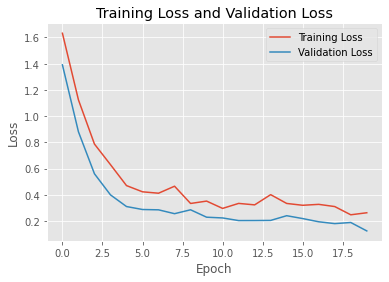

In [11]:
N = EPOCHS

plt.figure()
plt.plot(np.arange(0, N), HR2.history["loss"], label="Training Loss")
plt.plot(np.arange(0, N), HR2.history["val_loss"], label="Validation Loss")
plt.title("Training Loss and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

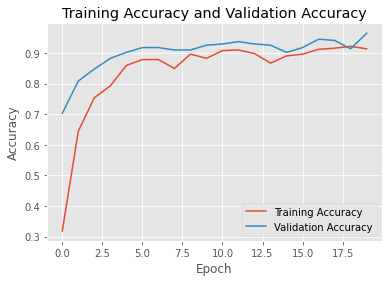

In [12]:
plt.figure()
plt.plot(np.arange(0, N), HR2.history["accuracy"], label="Training Accuracy")
plt.plot(np.arange(0, N), HR2.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training Accuracy and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

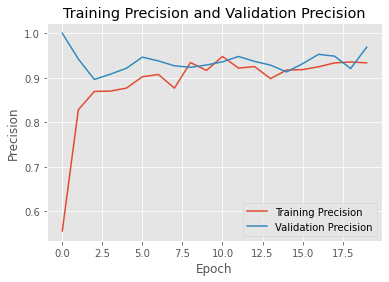

In [13]:
plt.figure()
plt.plot(np.arange(0, N), HR2.history["precision"], label="Training Precision")
plt.plot(np.arange(0, N), HR2.history["val_precision"], label="Validation Precision")
plt.title("Training Precision and Validation Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.legend(loc="lower right")

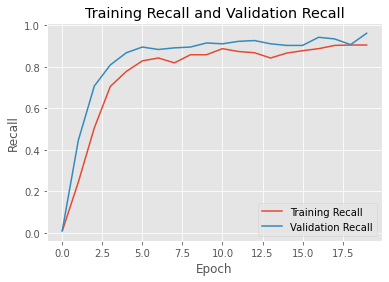

In [14]:
plt.figure()
plt.plot(np.arange(0, N), HR2.history["recall"], label="Training Recall")
plt.plot(np.arange(0, N), HR2.history["val_recall"], label="Validation Recall")
plt.title("Training Recall and Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend(loc="lower right")

## ***Generate Predictions***

In [15]:
pred_path = "/kaggle/input/intel-image-classification/seg_pred/seg_pred"

In [16]:
def mapper(val):
    if val == 0:
        return 'Buildings'
    elif val == 1:
        return 'Forest'
    elif val == 2:
        return 'Glacier'
    elif val == 3:
        return 'Mountain'
    elif val == 4:
        return 'Sea'
    elif val == 5:
        return 'Street'

In [17]:
def genPred(PATH,image):
    o_test_image = cv2.imread(os.path.join(PATH, image))
    o_test_image = cv2.cvtColor(o_test_image, cv2.COLOR_BGR2RGB)

    test_image = cv2.resize(o_test_image, image_size)
    test_image = preprocess_input(test_image)
    test_image = np.expand_dims(test_image, axis = 0)

    y_hat = model.predict(test_image)
    y_hat = np.argmax(y_hat, axis=1)
    pred_lab = mapper(y_hat)

    print("===========================================================================================")
    print("PREDICTED LABEL: "+pred_lab)
    print("===========================================================================================")
    print("")

    plt.imshow(o_test_image)

PREDICTED LABEL: Buildings



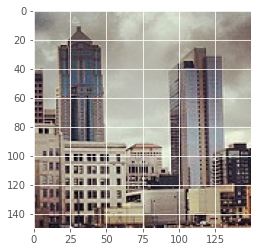

In [18]:
genPred(pred_path, '10052.jpg')

PREDICTED LABEL: Forest



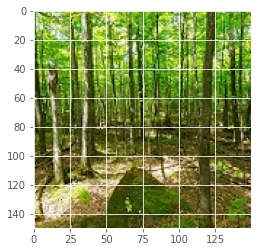

In [19]:
genPred(pred_path, '10059.jpg')

PREDICTED LABEL: Mountain



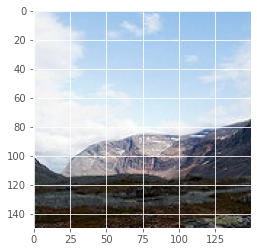

In [20]:
genPred(pred_path, '10005.jpg')

PREDICTED LABEL: Street



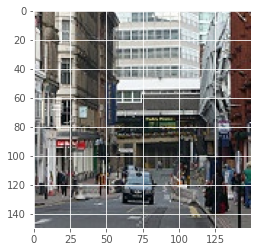

In [21]:
genPred(pred_path, '10012.jpg')

PREDICTED LABEL: Sea



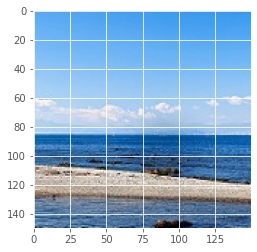

In [22]:
genPred(pred_path, '1003.jpg')

PREDICTED LABEL: Glacier



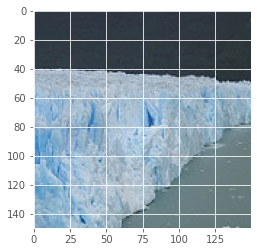

In [23]:
genPred(pred_path, '10034.jpg')